In [1]:
import pandas as pd
from preprocess import Audio_Processor
from sklearn import metrics
from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os
from sklearn.neighbors import KNeighborsClassifier as KNN

Using TensorFlow backend.


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"

SR = 44100
blocksize = 88200
overlap = 22050

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
audio_dir = '../ESC-50/audio/'

In [5]:
path_to_db='../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/')

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [6]:
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50

In [7]:
h_classes = ['Human & Animal', 'Interacting Materials']
mapping = {'dog': 0,'rooster': 0,'pig': 0,'cow': 0,'frog': 0,'cat': 0,'hen': 0,
            'insects': 0,'sheep': 0,'crow': 0,'rain': 1,'sea_waves': 1,'crackling_fire': 1,
            'crickets': 0,'chirping_birds': 0,'water_drops': 1,'wind': 1,'pouring_water': 1,
            'toilet_flush': 1,'thunderstorm': 1,'crying_baby': 0,'sneezing': 0,'clapping': 0,
            'breathing': 0,'coughing': 0,'footsteps': 1,'laughing': 0,'brushing_teeth': 1,
            'snoring': 0,'drinking_sipping': 1,'door_wood_knock': 1,'mouse_click': 1,
            'keyboard_typing': 1,'door_wood_creaks': 1,'can_opening': 1,'washing_machine': 1,
            'vacuum_cleaner': 1,'clock_alarm': 1,'clock_tick': 1,'glass_breaking':1,'helicopter': 1,
            'chainsaw': 1,'siren': 1,'car_horn': 1,'engine': 1,'train': 1,'church_bells': 1,
            'airplane': 1,'fireworks': 1,'hand_saw': 1,
            }

In [8]:
dataset['h_category'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_category'] = mapping[row['category']]

In [9]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take,h_category
0,1-100032-A-0.wav,1,0,dog,True,100032,A,0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,0
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,1
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,1
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1


## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [10]:
df = ps.preprocess_fold(dataset, 
                        kind='mfcc', 
                        fld=range(2,6), 
                        blocksize=blocksize, 
                        overlap=overlap)

In [11]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,106,107,108,109,110,111,112,113,l_target,h_target
count,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000,...,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000,4538.000000
mean,0.271778,0.277427,0.196409,0.172584,0.155856,0.147383,0.137123,0.137427,0.127727,0.125805,...,-0.000042,0.000060,-0.000030,0.000046,-0.000036,0.000034,-0.000015,0.000021,0.623402,24.497135
std,0.152690,0.154592,0.088349,0.075266,0.066213,0.060945,0.056277,0.057575,0.051265,0.050852,...,0.000670,0.000621,0.000643,0.000617,0.000649,0.000603,0.000628,0.000569,0.484586,14.519294
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.017461,-0.005907,-0.005809,-0.009156,-0.016274,-0.005280,-0.003952,-0.006403,0.000000,0.000000
25%,0.146685,0.143912,0.133364,0.120063,0.111619,0.106004,0.100349,0.097655,0.094181,0.091991,...,-0.000126,-0.000040,-0.000111,-0.000045,-0.000105,-0.000051,-0.000093,-0.000049,0.000000,12.000000
50%,0.255615,0.270452,0.197800,0.172240,0.155154,0.147672,0.136195,0.137088,0.127714,0.125865,...,-0.000029,0.000025,-0.000024,0.000015,-0.000021,0.000007,-0.000014,0.000004,1.000000,24.000000
75%,0.372589,0.387784,0.252908,0.220791,0.197310,0.184662,0.170713,0.173707,0.158522,0.156500,...,0.000032,0.000121,0.000035,0.000100,0.000036,0.000087,0.000043,0.000082,1.000000,37.000000
max,0.782623,0.839244,0.561361,0.483876,0.458426,0.454676,0.490386,0.424678,0.377254,0.407372,...,0.030503,0.030503,0.030503,0.030503,0.030503,0.030503,0.030503,0.030503,1.000000,49.000000


In [12]:
from sklearn.model_selection import train_test_split
train, test, = train_test_split(
                        df, test_size=0.20, random_state=42)

In [13]:
from sklearn.preprocessing import normalize

train_X = normalize(train.drop(['l_target', 'h_target'], axis=1))
train_y = train['l_target']
test_X = normalize(test.drop(['l_target', 'h_target'], axis=1))
test_y = test['l_target']

# KNN Grid Search

In [14]:
from sklearn.model_selection import GridSearchCV
params = {
          'n_neighbors': range(5,25,1),
          'algorithm': ('ball_tree', 'kd_tree', 'brute')
         }

knn = KNN(n_neighbors=15, algorithm='ball_tree')

clf = GridSearchCV(knn, params, cv=5)

clf.fit(train_X, train_y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=15, p=2,
           weights='uniform'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': range(5, 25), 'algorithm': ('ball_tree', 'kd_tree', 'brute')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [15]:
sorted(clf.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'mean_train_score',
 'param_algorithm',
 'param_n_neighbors',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split0_train_score',
 'split1_test_score',
 'split1_train_score',
 'split2_test_score',
 'split2_train_score',
 'split3_test_score',
 'split3_train_score',
 'split4_test_score',
 'split4_train_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score',
 'std_train_score']

0.8061674008810573
Confusion matrix, without normalization
[[227 124]
 [ 52 505]]


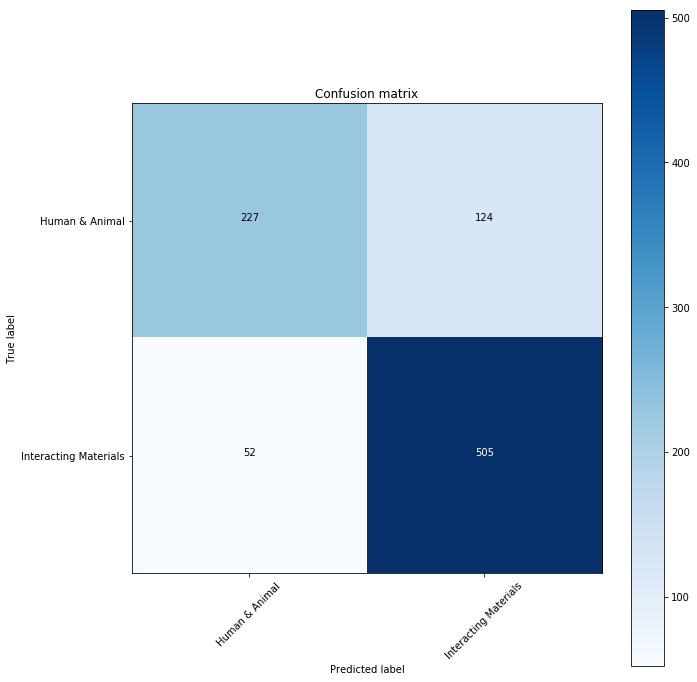

In [16]:
pred = clf.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

# All Data

In [17]:
all_df = ps.preprocess_fold(dataset, 
                        kind='mfcc', 
                        fld=1, 
                        blocksize=blocksize, 
                        overlap=overlap)

In [18]:
X = all_df.drop(['l_target', 'h_target'], axis=1)
y = all_df['l_target']

0.7202486678507993
Confusion matrix, without normalization
[[213 209]
 [106 598]]


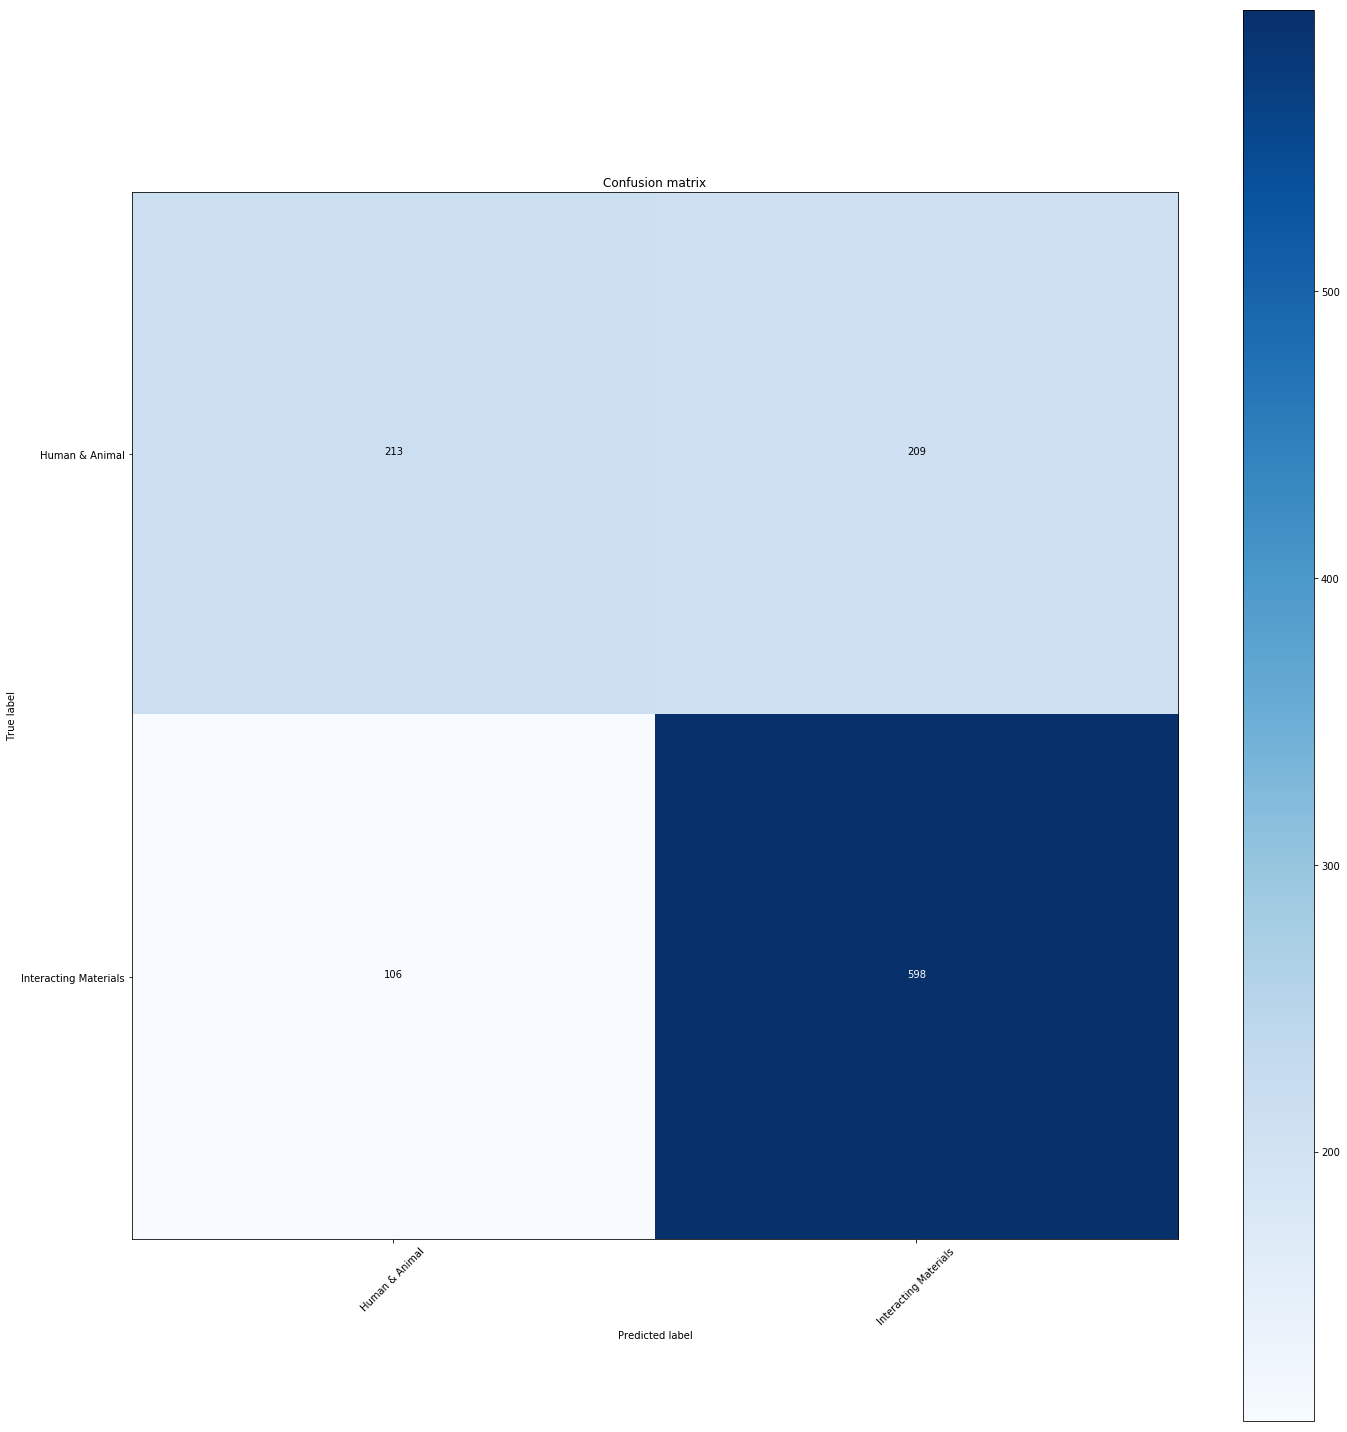

In [19]:
pred = clf.predict(X)
print(metrics.accuracy_score(y, pred))
cm = metrics.confusion_matrix(y, pred)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, h_classes)
plt.show()

In [20]:
import seaborn as sns
misclassified = {
    'h_target': [],
    'l_target': []
}
for row, p, Y in zip(all_df.iterrows(), pred, y):
    if p != Y:
        misclassified['h_target'].append(classes[int(row[1]['h_target'])])
        misclassified['l_target'].append(h_classes[Y])

misclassified = pd.DataFrame.from_dict(misclassified)
misclassified.head()

,h_target,l_target
0,dog,Human & Animal
1,chirping_birds,Human & Animal
2,chirping_birds,Human & Animal
3,chirping_birds,Human & Animal
4,can_opening,Interacting Materials


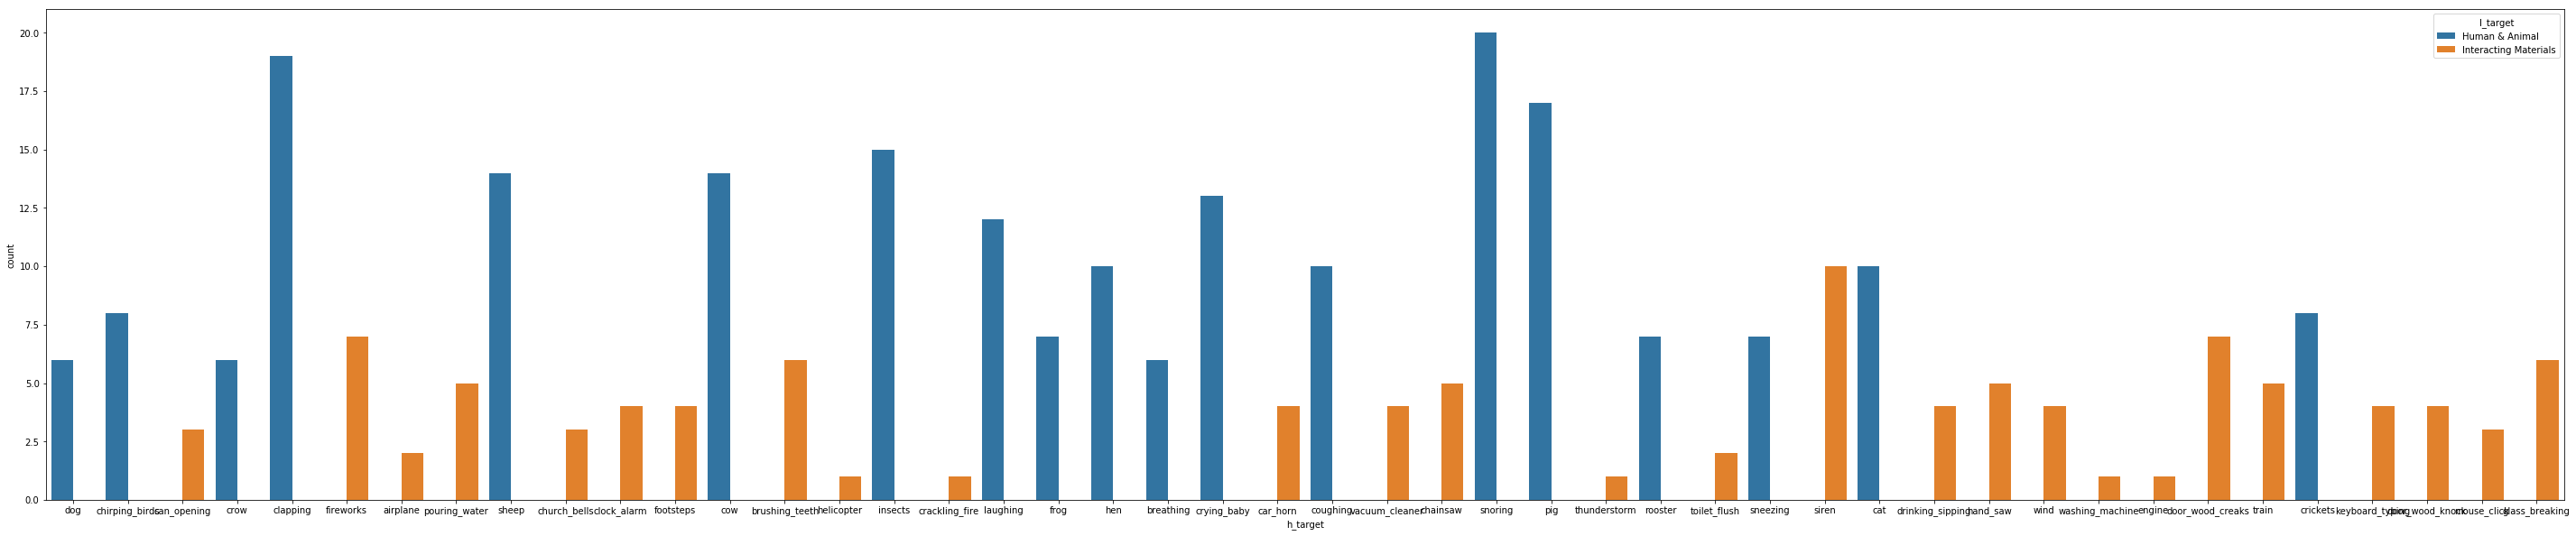

In [21]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(50,10))
sns.countplot(x='h_target', hue='l_target',data=misclassified)